In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import time

file_path = 'preprocessed_crimes_data.csv'
df = pd.read_csv(file_path)
df.rename(columns={'Primary Type': 'Crime_Type'}, inplace=True)

print("Missing values:\n", df.isnull().sum())

df.head(5)

Missing values:
 Date                    0
Year                    0
Longitude               0
Latitude                0
Location Description    0
Crime_Type              0
Description             0
dtype: int64


,Date,Year,Longitude,Latitude,Location Description,Crime_Type,Description
0,653295,2015.0,-87.67145,41.842259,23,9,232
1,3184228,2018.0,-87.67145,41.842259,17,9,231
2,1048861,2016.0,-87.67145,41.842259,189,9,232
3,3184254,2018.0,-87.67145,41.842259,160,26,470
4,1338752,2014.0,-87.67145,41.842259,160,9,232


## Common functions for metrics

In [17]:
# precision, recall, and F1 score
def print_metrics(y_test, y_test_pred):
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')

In [18]:
def print_class_report_conf_matrix(y_test, y_test_pred):
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    print('Confusion Matrix:')
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, y_test_pred)
    print('Classification Report:')
    print(class_report)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Accuracy Score: {accuracy * 100:.2f}%')
    print_metrics(y_test, y_test_pred)

In [19]:
def show_roc_auc_curve(X_test, y_test, model):
    y_test_bin = label_binarize(y_test, classes=model.classes_)
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve
    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
    plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7916515 entries, 0 to 7916514
Data columns (total 7 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Date                  int64  
 1   Year                  float64
 2   Longitude             float64
 3   Latitude              float64
 4   Location Description  int64  
 5   Crime_Type            int64  
 6   Description           int64  
dtypes: float64(3), int64(4)
memory usage: 422.8 MB


## Splitting into training, testing and validation datasets

In [21]:
target_col = 'Crime_Type'
X = df.drop(target_col, axis=1)
y = df[target_col]

# Split the data into training, testing, and validation sets
# 70:20:10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print(len(X_train), len(y_train), len(X_test), len(y_test), len(X_val), len(y_val))

5541560 5541560 1591219 1591219 783736 783736


## Baseline Model

In [22]:
start_time = time.time()
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Now make predictions on the test set
y_test_pred = classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Validation Accuracy: 92.73%
Test Accuracy: 92.77%
Training time: 63.09990930557251 seconds


In [23]:
print_metrics(y_test, y_test_pred)

Precision: 0.928
Recall: 0.928
F1 Score: 0.928


In [24]:
print_class_report_conf_matrix(y_test, y_test_pred)

Confusion Matrix:
[[  2514      0      0 ...     19      0      0]
 [     0  51587  52246 ...    458      0      0]
 [     0  53212 236296 ...    456      0      0]
 ...
 [    13    385    423 ...    204      0      0]
 [     0      0      0 ...      0 335975      0]
 [     0      0      0 ...      0      0  22254]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2683
           1       0.49      0.49      0.49    104630
           2       0.82      0.81      0.82    290171
           3       1.00      1.00      1.00     86378
           4       0.96      0.93      0.94       238
           5       0.88      0.89      0.89      5696
           6       0.98      0.98      0.98    181609
           7       0.80      0.79      0.80      1579
           8       0.93      0.94      0.93     43429
           9       1.00      1.00      1.00     70841
          11       0.99      0.99      0.99      2915
          

C:\Users\16284\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\16284\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


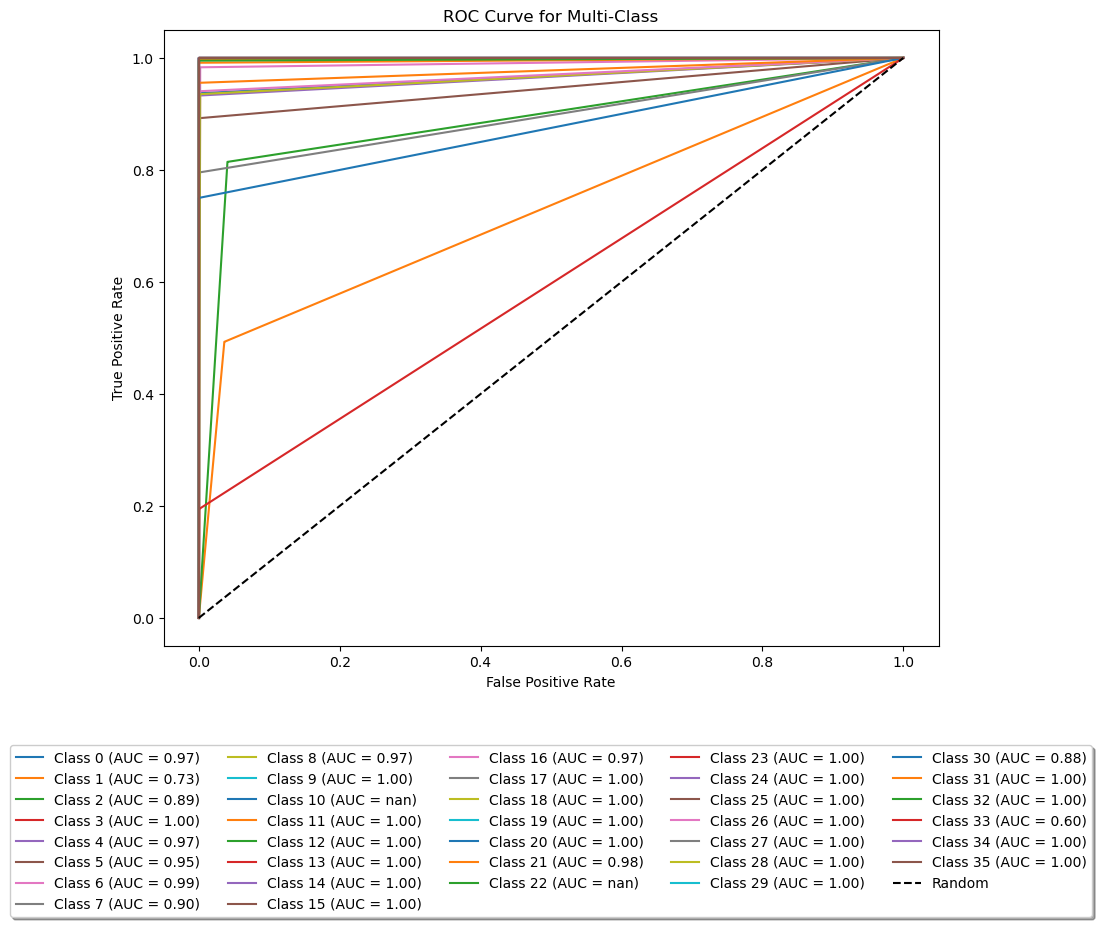

In [25]:
show_roc_auc_curve(X_test, y_test, classifier)

In [5]:
# Save the trained model
model_filename = 'dt_model_baseline.joblib'
joblib.dump(classifier, model_filename)
print(f'Model saved to {model_filename}')

Model saved to dt_model_org_dataset.joblib


## Do GridSearch to find best hyperparameters for decision tree classifier

In [15]:
dtree = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Use GridSearchCV to do grid search
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)
print("Accuracy on Test Set:", accuracy)

Best Hyperparameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy on Test Set: 0.9427960576136911


## Hyperparameter tuned model

In [26]:
start_time = time.time()
best_clssifier = DecisionTreeClassifier(criterion='entropy',
                                        max_depth=15,
                                        max_features=None,
                                        min_samples_leaf=4,
                                        min_samples_split=5)

best_clssifier.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = best_clssifier.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

# Now make predictions on the test set
y_test_pred = best_clssifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Validation Accuracy: 94.27%
Test Accuracy: 94.28%
Training time: 62.416982889175415 seconds


In [27]:
print_metrics(y_test, y_test_pred)

Precision: 0.939
Recall: 0.943
F1 Score: 0.940


In [28]:
print_class_report_conf_matrix(y_test, y_test_pred)

Confusion Matrix:
[[  2606      0      0 ...      0      0      0]
 [     0  47724  56903 ...      0      0      0]
 [     0  28910 261258 ...      0      0      0]
 ...
 [    17    380    440 ...    191      0      0]
 [     0      0      0 ...      0 335975      0]
 [     0      0      0 ...      0      0  22254]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2683
           1       0.62      0.46      0.52    104630
           2       0.82      0.90      0.86    290171
           3       1.00      1.00      1.00     86378
           4       0.97      0.96      0.96       238
           5       0.95      0.92      0.93      5696
           6       0.98      1.00      0.99    181609
           7       0.96      0.74      0.84      1579
           8       1.00      0.93      0.96     43429
           9       1.00      1.00      1.00     70841
          11       0.99      0.99      0.99      2915
          

C:\Users\16284\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\16284\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


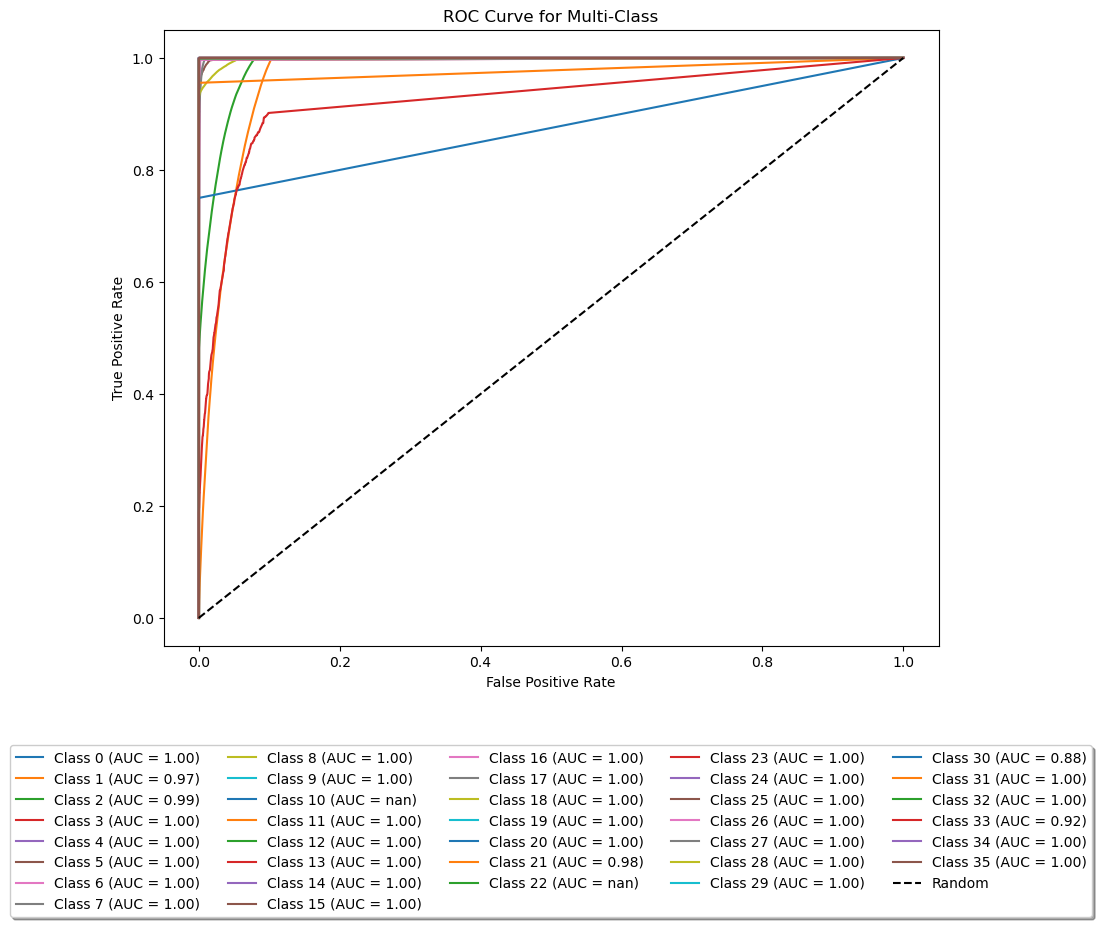

In [29]:
show_roc_auc_curve(X_test, y_test, best_clssifier)

In [30]:
# Save the trained model
model_filename = 'dt_hyperparameter_tuning_model.joblib'
joblib.dump(best_clssifier, model_filename)
print(f'Model saved to {model_filename}')

Model saved to dt_hyperparameter_tuning_model.joblib
